In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('/Users/mrseleznev/Desktop/проект/train.csv', sep=';')

In [3]:
df.rename(columns={'Store_ID': 'Store_id', 'SKU_ID': 'SKU_id'}, inplace=True)

In [4]:
df.shape

(23745497, 6)

In [5]:
#df = df.loc[df['Stock'] > df['Sales']]

df['Demand'] = df.loc[:, 'Sales']

#df['Demand'] = df.loc[df['Stock'] > 0, 'Sales']
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)

In [7]:
level_values = df.index.get_level_values
df_w = (df.groupby([level_values(i) for i in [0,1]]
                      +[pd.Grouper(freq='W', level=-1)]).mean())
# агрегация исходных данные в разрезе SKU|Store|Week

In [8]:
df_w.reset_index(inplace=True)
df.reset_index(inplace=True)

In [9]:
df

,SKU_id,Store_id,Date,Sales,Stock,Regular_Price,Demand
0,114,1100,2019-01-01,0.0,1.0,51.0,0.0
1,114,1078,2019-01-01,0.0,2.0,51.0,0.0
2,114,1191,2019-01-01,0.0,2.0,53.0,0.0
3,114,2230,2019-01-01,0.0,1.0,40.0,0.0
4,114,1120,2019-01-01,0.0,1.0,53.0,0.0
...,...,...,...,...,...,...,...
23745492,337810,1092,2019-12-28,1.0,0.0,144.0,1.0
23745493,337810,2710,2019-12-28,1.0,0.0,154.0,1.0
23745494,337810,1117,2019-12-29,1.0,0.0,151.0,1.0
23745495,337810,2834,2019-12-29,1.0,0.0,151.0,1.0


In [10]:
df_w

,SKU_id,Store_id,Date,Sales,Stock,Regular_Price,Demand
0,114,1078,2019-01-06,0.166667,2.000000,51.0,0.166667
1,114,1078,2019-01-13,0.000000,1.714286,51.0,0.000000
2,114,1078,2019-01-20,0.000000,1.571429,51.0,0.000000
3,114,1078,2019-01-27,0.142857,1.285714,51.0,0.142857
4,114,1078,2019-02-03,0.000000,1.000000,51.0,0.000000
...,...,...,...,...,...,...,...
5773537,337810,2853,2019-10-13,2.000000,0.000000,205.0,2.000000
5773538,337810,2853,2019-10-20,1.000000,0.000000,151.0,1.000000
5773539,337810,2853,2019-10-27,1.000000,0.000000,151.0,1.000000
5773540,337810,2853,2019-11-03,2.000000,0.000000,151.0,2.000000


In [11]:
sku_store_count_day = len(set(zip(df['SKU_id'], df['Store_id'])))
sku_store_count_week = len(set(zip(df_w['SKU_id'], df_w['Store_id'])))
print(sku_store_count_day, sku_store_count_day == sku_store_count_week)

260551 True


Кол-во пар sku|store в df такое же как и в df_w

In [12]:
popular_pairs = df.groupby(['SKU_id', 'Store_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
popular_pairs

,SKU_id,Store_id,counts
0,14409,2834,363
1,137749,2834,363
2,146728,2834,363
3,11412,2834,363
4,7340,2834,363
...,...,...,...
260546,143068,1777,1
260547,143068,1780,1
260548,9166,2232,1
260549,314710,1104,1


In [13]:
popular_pairs = df_w.groupby(['SKU_id', 'Store_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
popular_pairs

,SKU_id,Store_id,counts
0,96356,1099,52
1,16265,1095,52
2,16265,1085,52
3,16265,1086,52
4,16265,1091,52
...,...,...,...
260546,63040,1854,1
260547,63040,1494,1
260548,144011,1120,1
260549,63040,1115,1


Получается, что в df о sku|store описано максимум 90 дней

В df_w о sku|store описано максимум 13 недель

In [14]:
def transform(x, ttype):
    '''
    Accepts vector and performs transformation on it based on ttype
    '''
    if ttype == 'log':
        return np.log1p(x)
    
    return np.array(x)

In [15]:
def coef(model):
    """
    return regression coefficient of model
    """
    return model.params[1] if len(model.params) > 1 else model.params[0]

def pvalue(model):
    """
    return regression coefficient's t-test p-value of model
    """
    return model.pvalues[1] if len(model.pvalues) > 1 else model.pvalues[0]

In [16]:
def elasticity(X, y, model, model_type):
    '''
    Computes elasticity of model based on X, y, model itself and model's type
    '''
    if model_type == 'lin-lin':
        return coef(model) * np.mean(X) / np.mean(y)
    elif model_type == 'log-lin':
        return coef(model) * np.mean(X)
    elif model_type == 'log-log':
        return coef(model)

In [17]:
def PEDmodel(X, y, model_type='lin-lin'):
    '''
    Makes PED model based on input data X, y and model type
    '''
    _types = model_type.split('-')
    
    act_x = transform(X, _types[1])
    act_x = sm.add_constant(act_x)
    
    act_y = transform(y, _types[0])
    
    return sm.OLS(act_y, act_x).fit()

In [18]:
def get_model_stats(X, y, model, model_type):
    '''
    returns model's statistics
        regression coefficient,
        R-squared,
        T-test p-value,
        elasticity
    '''
    elas = elasticity(X, y, model, model_type)
    
    return coef(model), model.rsquared, pvalue(model), elas

In [19]:
popular_pairs_day = df.groupby(['SKU_id', 'Store_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)
popular_pairs_week = df_w.groupby(['SKU_id', 'Store_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False).reset_index(drop=True)


def GeneratePEDModels(dataset, date_type='day'):
    all_model_types = ['log-log']
    sku_id, store_id, coeff, rsquared, ttpvalue, elas, mtype = [], [], [], [], [], [], []
    qty = []
    sample_sizes = []
    
    if date_type == 'day':
        global_sample_sizes = [x for x in range(60, 361, 50)]
        popular_pairs = popular_pairs_day
    if date_type == 'week':
        global_sample_sizes = [x for x in range(10, 51, 10)]
        popular_pairs = popular_pairs_week
        
    pairs_for_experiment = []
    for i, r in popular_pairs.iterrows():
        #всего пар sku|store в нашей выборке 
        if i == 100000:
            break
        pairs_for_experiment.append((r['SKU_id'], r['Store_id']))
    
    
        
    #идем по всем парам sku|store
    for good_id, shop_id in pairs_for_experiment:
        #выбираем строки с конкретным значением sku|store
        pairs_data = dataset[(dataset.Store_id == shop_id) & (dataset.SKU_id == good_id)]
        if pairs_data.Demand.sum() == 0:
            continue
        #идем по всем размерам
        for current_sample_size in global_sample_sizes:
            #делаем проверку на SampleSize (достаточность)
            if pairs_data.shape[0] < current_sample_size:
                break
            #разбиваем данные на сэмплы
            data = pairs_data.sample(n=current_sample_size, replace=False)
            #делаем проверку на то, что если у нас всего одно значение demand и оно 0 или если такой пары sku|store нету
            if (len(data.Demand) == 1 and data.loc[0, 'Demand'] == 0) or data.empty == True or data.Demand.sum() == 0:
                continue
            #суммируем спрос
            curQty = data.Demand.sum()
            #теперь идем по всем моделям
            for model_type in all_model_types:
                #строим модель где в роли признака - цена, таргет - спрос
                model = PEDmodel(data.Regular_Price, data.Demand, model_type)
                #считаем статистику
                c, r2, tp, e = get_model_stats(data.Regular_Price, data.Demand, model, model_type)

                sku_id.append(good_id)
                store_id.append(shop_id)
                coeff.append(c)
                rsquared.append(r2)
                ttpvalue.append(tp)
                elas.append(e)
                mtype.append(model_type)
                qty.append(curQty)
                sample_sizes.append(current_sample_size)
    
    return pd.DataFrame({
        'SKU': sku_id,
        'Store': store_id,
        'Coefficient': coeff,
        'R-squared': rsquared,
        'T-test-p-value': ttpvalue,
        'Model-type': mtype,
        'Elasticity': elas,
        'Qty': qty,
        'SampleSize': sample_sizes
    })

In [20]:
sample_data_day = GeneratePEDModels(df)
sample_data_day['Гранулярность эластичности'] = 'SKU|Store'
sample_data_day['Гранулярность trainset'] = 'SKU|Store|Day'
#sample_data.to_csv('sample_data.csv', index=False)

/Users/mrseleznev/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
sample_data_week = GeneratePEDModels(df_w, date_type='week')
sample_data_week['Гранулярность эластичности'] = 'SKU|Store'
sample_data_week['Гранулярность trainset'] = 'SKU|Store|Week'

/Users/mrseleznev/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/mrseleznev/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/mrseleznev/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


In [22]:
sample_data_day.to_csv('sample_data_day.csv', index=False)
sample_data_day

,SKU,Store,Coefficient,R-squared,T-test-p-value,Model-type,Elasticity,Qty,SampleSize,Гранулярность эластичности,Гранулярность trainset
0,14409,2834,1.425431,0.026615,2.129620e-01,log-log,1.425431,670.0,60,SKU|Store,SKU|Store|Day
1,14409,2834,1.970086,0.066935,6.350822e-03,log-log,1.970086,1153.0,110,SKU|Store,SKU|Store|Day
2,14409,2834,1.538081,0.046024,6.446748e-03,log-log,1.538081,1580.0,160,SKU|Store,SKU|Store|Day
3,14409,2834,2.008354,0.076231,4.985460e-05,log-log,2.008354,2034.0,210,SKU|Store,SKU|Store|Day
4,14409,2834,2.177756,0.092063,6.132965e-07,log-log,2.177756,2582.0,260,SKU|Store,SKU|Store|Day
...,...,...,...,...,...,...,...,...,...,...,...
204154,134704,1178,2.871509,0.124205,5.750645e-03,log-log,2.871509,27.0,60,SKU|Store,SKU|Store|Day
204155,72009,1878,-5.422275,0.194394,4.221228e-04,log-log,-5.422275,10.0,60,SKU|Store,SKU|Store|Day
204156,23129,2689,0.676292,0.028928,1.938636e-01,log-log,0.676292,8.0,60,SKU|Store,SKU|Store|Day
204157,64654,1134,0.469475,0.006056,5.544992e-01,log-log,0.469475,4.0,60,SKU|Store,SKU|Store|Day


In [23]:
sample_data_week.to_csv('sample_data_week.csv', index=False)
sample_data_week

,SKU,Store,Coefficient,R-squared,T-test-p-value,Model-type,Elasticity,Qty,SampleSize,Гранулярность эластичности,Гранулярность trainset
0,96356,1099,2.914160,0.290488,0.107925,log-log,2.914160,11.821429,10,SKU|Store,SKU|Store|Week
1,96356,1099,0.866351,0.135330,0.110536,log-log,0.866351,28.416667,20,SKU|Store,SKU|Store|Week
2,96356,1099,1.324115,0.136009,0.044914,log-log,1.324115,39.190476,30,SKU|Store,SKU|Store|Week
3,96356,1099,1.130205,0.078695,0.079543,log-log,1.130205,53.311905,40,SKU|Store,SKU|Store|Week
4,96356,1099,1.217023,0.117992,0.014594,log-log,1.217023,67.769048,50,SKU|Store,SKU|Store|Week
...,...,...,...,...,...,...,...,...,...,...,...
322483,126336,1091,6.643115,0.571490,0.000115,log-log,6.643115,10.714286,20,SKU|Store,SKU|Store|Week
322484,325632,1177,1.244839,0.061347,0.490225,log-log,1.244839,5.714286,10,SKU|Store,SKU|Store|Week
322485,325632,1177,2.763044,0.314514,0.010101,log-log,2.763044,10.857143,20,SKU|Store,SKU|Store|Week
322486,23394,1123,1.885329,0.145960,0.275943,log-log,1.885329,6.142857,10,SKU|Store,SKU|Store|Week


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
Y = ['Coefficient', 'R-squared', 'Elasticity']

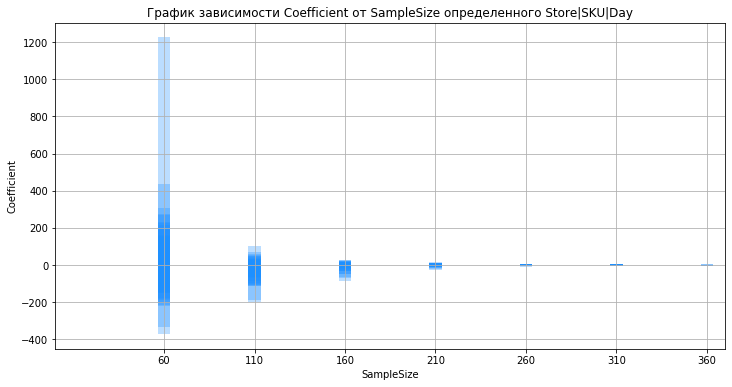

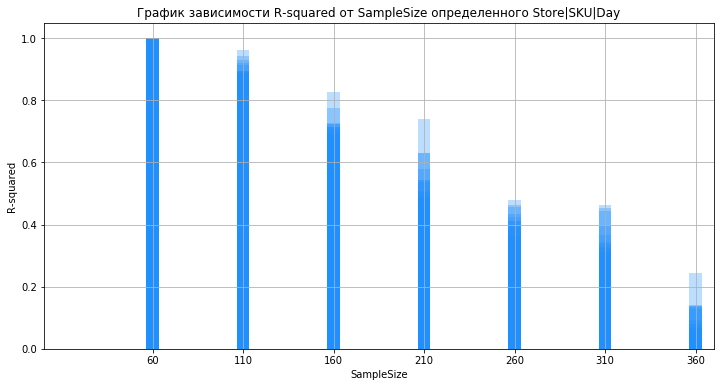

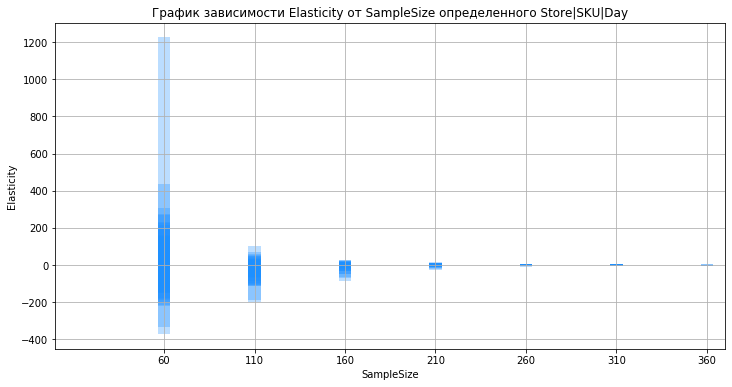

In [26]:
for y in Y:
    fig, ax = plt.subplots()
    ax.bar(x=sample_data_day['SampleSize'], height=sample_data_day[y], 
           width=7, color='dodgerblue', alpha=0.3)
    plt.xlim([0, 370])      #  диапазон оси x
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(6)    #  высота Figure
    plt.xticks([x for x in range(60, 361, 50)])
    plt.grid() # сетка
    
    plt.xlabel('SampleSize')
    plt.ylabel(y)
    plt.title('График зависимости ' + y + ' от SampleSize определенного Store|SKU|Day')
    
    plt.show()

1) Можно заметить, что основные значения coef. лежат в диапазоне [-15; 20], вне зависимости от SampleSize

2) Значения R-квадрата по идее всегда должны быть большими, так как цена и спрос сильно между собой коррелируют (на спрос влияют какие-то другие признаки помимо цены)

3) Вне зависимости от SampleSize эластичность принимает значения [-20; 20]

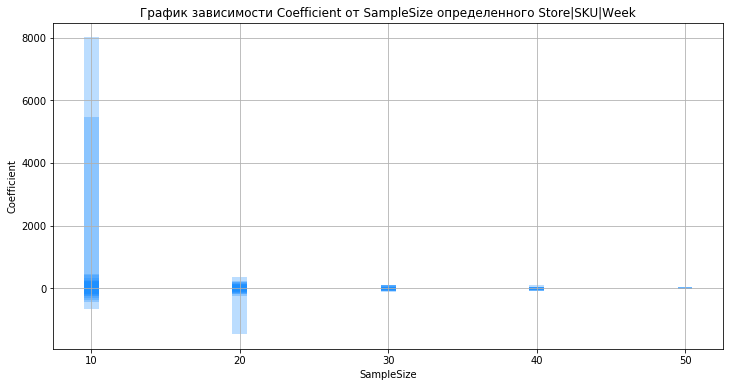

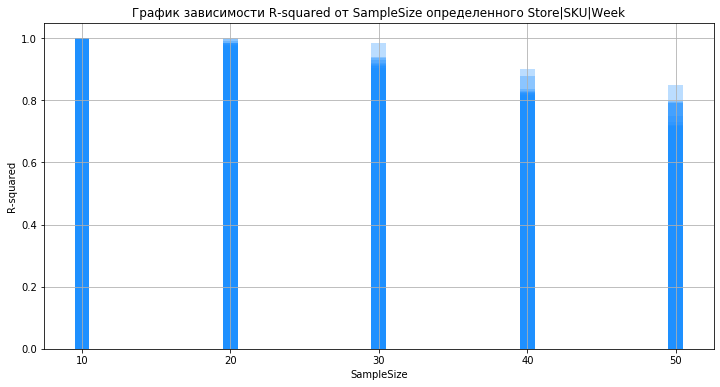

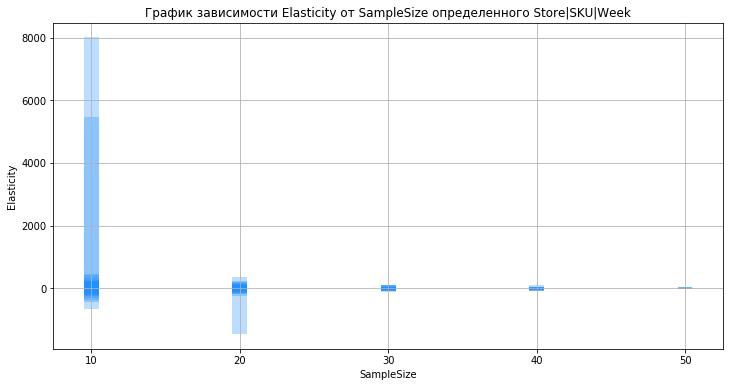

In [27]:
for y in Y:
    fig, ax = plt.subplots()
    ax.bar(x=sample_data_week['SampleSize'], height=sample_data_week[y], 
           width=1, color='dodgerblue', alpha=0.3)
    #plt.xlim([0, 13])      #  диапазон оси x
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(6)    #  высота Figure
    plt.xticks([x for x in range(10, 51, 10)])
    plt.grid() # сетка
    
    plt.xlabel('SampleSize')
    plt.ylabel(y)
    plt.title('График зависимости ' + y + ' от SampleSize определенного Store|SKU|Week')
    
    plt.show()

Получается, что при гранулярности Store|SKU|Day, разброс статистик меньше, чем при Store|SKU|Week

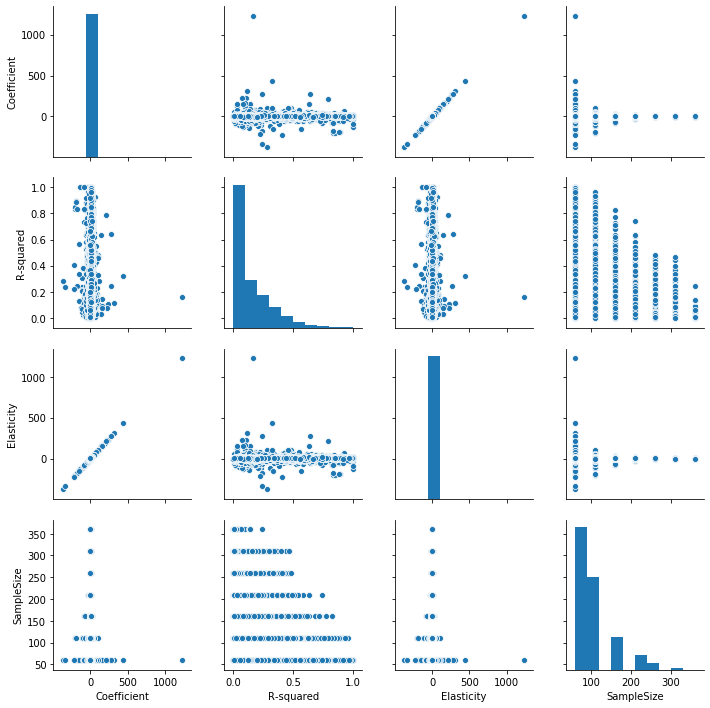

In [28]:
sns.pairplot(sample_data_day[Y + ['SampleSize']]);

In [38]:
#sns.pairplot(sample_data_week[Y + ['SampleSize']]);

# Подсчет адекватных значений

In [30]:
#адекватные значения
min_elast, max_elast = -10, 0
p_value = 0.05

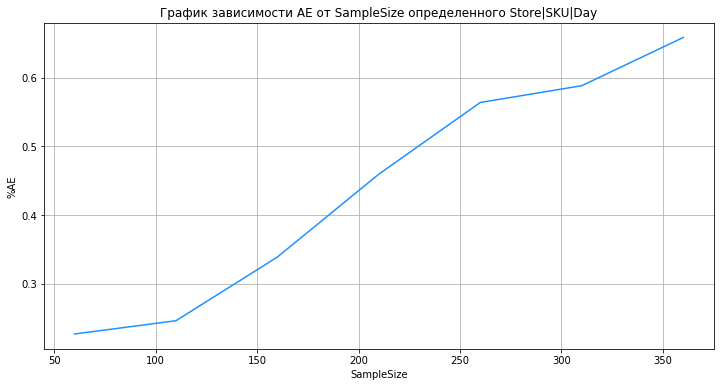

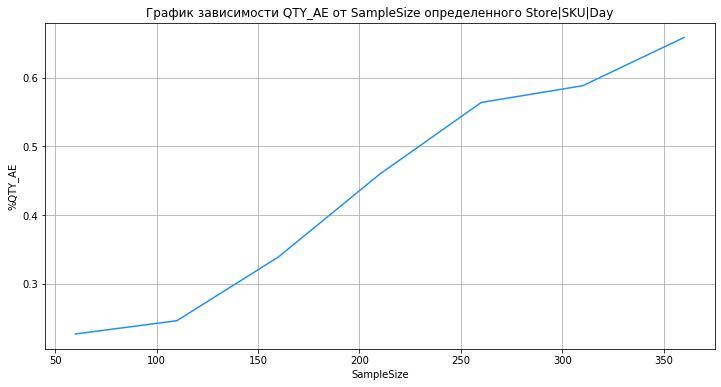

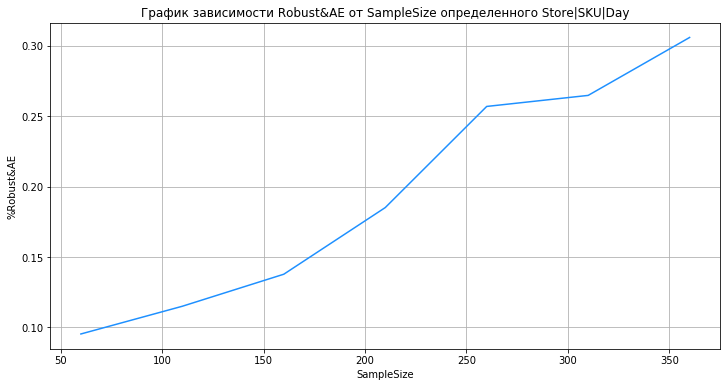

In [31]:
#считаем адекватные значения для SKU_id|Store_id|Day

sample_data_day['AE'] = ((sample_data_day.loc[:, 'Elasticity'] > min_elast) & 
                             (sample_data_day.loc[:, 'Elasticity'] < max_elast )).astype(int)

sample_data_day['QTY_AE'] = np.logical_and(sample_data_day['AE'], sample_data_day['Qty'])

sample_data_day['Robust&AE'] = np.logical_and(sample_data_day['AE'],
                                               (sample_data_day.loc[:, 'T-test-p-value'] < p_value))

sample_data_day_mean = sample_data_day.groupby('SampleSize').mean()
sample_data_day_mean.reset_index(inplace=True)

ae_stats = ['AE', 'QTY_AE', 'Robust&AE']
for ae_stat in ae_stats:
    fig, ax = plt.subplots()
    ax.plot(sample_data_day_mean.SampleSize, sample_data_day_mean[ae_stat], color='dodgerblue')
    #plt.xlim([0, 13])      #  диапазон оси x
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(6)    #  высота Figure
    #plt.xticks([x for x in range(10, 51, 10)])
    plt.grid() # сетка
    
    plt.xlabel('SampleSize')
    plt.ylabel('%' + ae_stat)
    plt.title('График зависимости ' + ae_stat + ' от SampleSize определенного Store|SKU|Day')
    
    plt.show()

In [32]:
#weighted_mean = lambda x: np.average(x, weights=sample_data_day.loc[x.index, "SampleSize"])
#f = {'SKU': ['count'], 'Store': ['count'], 'price': {'weighted_mean' : wm} }

In [33]:
sample_data_day.groupby('SampleSize').agg({'mean'})

,SKU,Store,Coefficient,R-squared,T-test-p-value,Elasticity,Qty,AE,QTY_AE,Robust&AE
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
SampleSize,,,,,,,,,,
60,84180.721920,1390.110700,1.589742,0.180869,0.142802,1.589742,44.734996,0.226500,0.226500,0.095360
110,80368.211469,1376.910353,1.317376,0.141996,0.129325,1.317376,108.459342,0.245816,0.245816,0.115049
160,70706.452503,1369.712083,0.580804,0.064842,0.193670,0.580804,261.954260,0.338720,0.338720,0.137783
210,68768.881694,1369.766796,0.072209,0.034189,0.242632,0.072209,465.982167,0.459591,0.459591,0.185102
260,71981.789820,1386.358271,-0.223548,0.028164,0.259486,-0.223548,768.789184,0.564063,0.564063,0.256911
310,76834.109739,1436.924554,-0.363455,0.028145,0.271027,-0.363455,1321.808642,0.588477,0.588477,0.264746
360,74302.294118,1859.952941,-0.719363,0.024862,0.237481,-0.719363,3408.555176,0.658824,0.658824,0.305882


In [34]:
sample_data_day.groupby(['SampleSize']).mean()

,SKU,Store,Coefficient,R-squared,T-test-p-value,Elasticity,Qty,AE,QTY_AE,Robust&AE
SampleSize,,,,,,,,,,
60,84180.721920,1390.110700,1.589742,0.180869,0.142802,1.589742,44.734996,0.226500,0.226500,0.095360
110,80368.211469,1376.910353,1.317376,0.141996,0.129325,1.317376,108.459342,0.245816,0.245816,0.115049
160,70706.452503,1369.712083,0.580804,0.064842,0.193670,0.580804,261.954260,0.338720,0.338720,0.137783
210,68768.881694,1369.766796,0.072209,0.034189,0.242632,0.072209,465.982167,0.459591,0.459591,0.185102
260,71981.789820,1386.358271,-0.223548,0.028164,0.259486,-0.223548,768.789184,0.564063,0.564063,0.256911
310,76834.109739,1436.924554,-0.363455,0.028145,0.271027,-0.363455,1321.808642,0.588477,0.588477,0.264746
360,74302.294118,1859.952941,-0.719363,0.024862,0.237481,-0.719363,3408.555176,0.658824,0.658824,0.305882


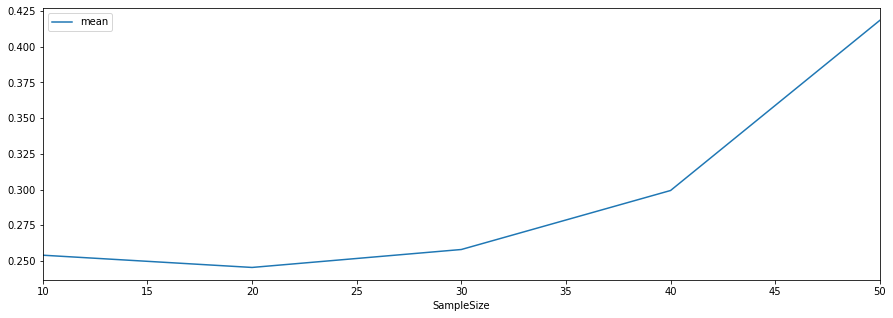

In [35]:
min_elast = -10
max_elast = 0
p_value = 0.05
#считаем адекватные значения
sample_data_week['AE'] = ((sample_data_week.loc[:, 'Elasticity'] > min_elast) & 
                             (sample_data_week.loc[:, 'Elasticity'] < max_elast )).astype(int)

sample_data_week['QTY_AE'] = np.logical_and(sample_data_week['AE'], sample_data_week['Qty'])

sample_data_week['Robust&AE'] = np.logical_and(sample_data_week['AE'],
                                               (sample_data_week.loc[:, 'T-test-p-value'] < p_value))

sample_data_week.groupby('SampleSize').agg({'mean'})['QTY_AE'].plot(figsize=(15, 5))

In [36]:
sample_data_week.groupby('SampleSize').mean()

,SKU,Store,Coefficient,R-squared,T-test-p-value,Elasticity,Qty,AE,QTY_AE,Robust&AE
SampleSize,,,,,,,,,,
10,85092.149450,1408.393950,1.567246,-inf,0.273143,1.567246,10.587652,0.254080,0.254080,0.039810
20,85092.149450,1408.393950,1.362550,-inf,0.198920,1.362550,21.164009,0.245510,0.245510,0.067750
30,81908.187843,1392.013266,1.129761,0.210872,0.189759,1.129761,35.543484,0.258069,0.258069,0.081146
40,74235.245518,1374.307708,0.737120,0.150067,0.212214,0.737120,55.898529,0.299375,0.299375,0.095959
50,65066.255027,1356.998795,0.196104,0.087162,0.274254,0.196104,90.958665,0.418468,0.418468,0.134744


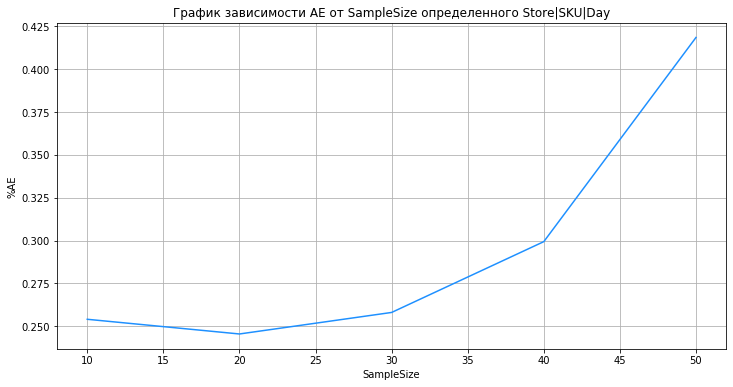

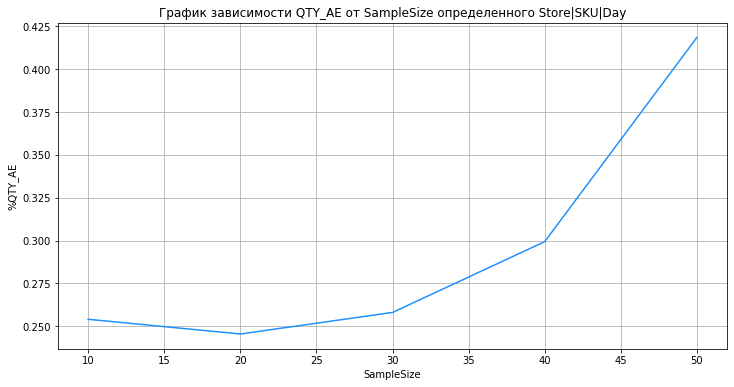

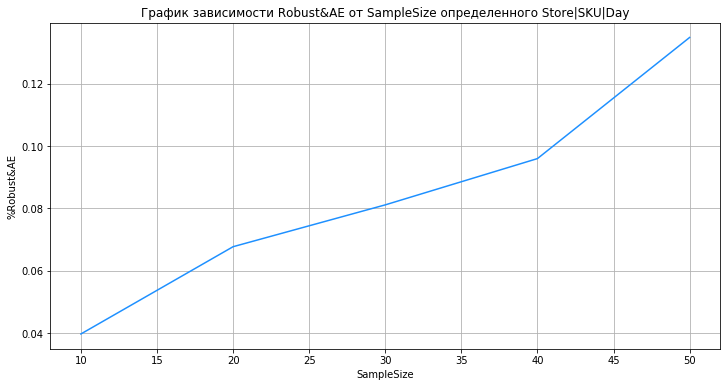

In [37]:
#считаем адекватные значения для SKU_id|Store_id|Week

sample_data_week['AE'] = ((sample_data_week.loc[:, 'Elasticity'] > min_elast) & 
                             (sample_data_week.loc[:, 'Elasticity'] < max_elast )).astype(int)

sample_data_week['QTY_AE'] = np.logical_and(sample_data_week['AE'], sample_data_week['Qty'])

sample_data_week['Robust&AE'] = np.logical_and(sample_data_week['AE'],
                                               (sample_data_week.loc[:, 'T-test-p-value'] < p_value))

sample_data_week_mean = sample_data_week.groupby('SampleSize').mean()
sample_data_week_mean.reset_index(inplace=True)

ae_stats = ['AE', 'QTY_AE', 'Robust&AE']
for ae_stat in ae_stats:
    fig, ax = plt.subplots()
    ax.plot(sample_data_week_mean.SampleSize, sample_data_week_mean[ae_stat], color='dodgerblue')
    #plt.xlim([0, 13])      #  диапазон оси x
    fig.set_figwidth(12)    #  ширина Figure
    fig.set_figheight(6)    #  высота Figure
    #plt.xticks([x for x in range(10, 51, 10)])
    plt.grid() # сетка
    
    plt.xlabel('SampleSize')
    plt.ylabel('%' + ae_stat)
    plt.title('График зависимости ' + ae_stat + ' от SampleSize определенного Store|SKU|Day')
    
    plt.show()